In [1]:
import pandas as pd
import numpy as np
import datetime
import pyxirr
import altair as alt
from alpha_vantage.timeseries import TimeSeries
# from alpha_vantage.foreignexchange import ForeignExchange
# from alpha_vantage.fundamentaldata import FundamentalData
from secrets import *

In [2]:
def ts(api_key):
    return TimeSeries(key=api_key, output_format='pandas', indexing_type='date')

# cc = ForeignExchange(key=api_key, output_format='pandas', indexing_type='date')
# fd = FundamentalData(key=api_key, output_format='pandas')

In [3]:
class Account:

    def __init__(self, currency, timeline):
        self.currency = currency
        self.name = 'CASH.' + self.currency
        self.internal_transactions = pd.Series(0, index=timeline)
        self.external_transactions = pd.Series(0, index=timeline)
    
    def internal_flow(self, date, amount):
        self.internal_transactions.at[date] = self.internal_transactions.at[date] + amount

    def external_flow(self, date, amount):
        self.external_transactions.at[date] = self.external_transactions.at[date] + amount

    def run(self):
        self.holdings = self.internal_transactions.cumsum()
        self.invested_capital = self.external_transactions.cumsum()

In [4]:
class Security:

    def __init__(self, name, timeline, api_key):
        self.name = name
        self.transactions = pd.Series(0, name=self.name, index=timeline)
        try:
            self.data = pd.read_csv(ROOT+'/data/'+self.name+'.csv', sep=',', index_col='date', parse_dates=True)
        except FileNotFoundError:
            self.data = ts(api_key).get_daily_adjusted(self.name, outputsize='full')[0].iloc[::-1]
            self.data.to_csv(ROOT+'/data/'+self.name+'.csv')
        self.data = self.data.reindex(index=timeline, method='nearest').fillna(method='ffill').loc[timeline[0]:timeline[-1]]
        self.prices = self.data['4. close']
        self.dividends = self.data['7. dividend amount']
        self.splits = self.data['8. split coefficient'].cumprod()
        # self.overview = fd.get_company_overview(symbol='MSFT')[0]
        # self.currency = self.overview['Currency']
        # self.sector = self.overview['Sector']

    def update(self, date, amount):
        self.transactions.at[date] = self.transactions.at[date] + amount

    def run(self):
        self.holdings = self.transactions.cumsum() * self.splits
        self.holdings_value_locale = self.holdings * self.prices
        self.holdings_value = self.holdings_value_locale.rename(self.name) # / fx_rate


In [5]:
class Portfolio:
    
    def __init__(self, filename, currency, api_key):
        self.data = pd.read_csv(filename, sep=',', index_col='Date', parse_dates=True).sort_index()
        self.api_key = api_key
        self.timeline = pd.date_range(start=self.data.index[0], end=datetime.date.today())
        self.currency = currency
        self.account = Account(self.currency, self.timeline)
        self.securities = dict() # dictionary with Security object at key='TICKER NAME'
        self._processed = False
    
    def run(self):
        if not self._processed:
            for date, transaction in self.data.iterrows():
                self.add_transaction(date, transaction)
            for security in self.securities.values():
                security.run()
                # add dividends to account
                self.account.internal_transactions = self.account.internal_transactions + security.dividends * security.holdings # / fx_rate
            self.account.run()
            self.join_holdings()
            self.generate_stats()
        self._processed = True

    def add_transaction(self, date, transaction):
        # pick correct function without ifs
        getattr(self, transaction.Order)(date, transaction)
    
    def deposit(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, transaction.Quantity * transaction.Price)

    def withdrawal(self, date, transaction):
        self.account.internal_flow(date, - transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, - transaction.Quantity * transaction.Price)
    
    def purchase(self, date, transaction):
        self.account.internal_flow(date,- transaction.Quantity * transaction.Price - transaction.Fee ) # / fx_rate
        tick = self.securities.setdefault(transaction.Ticker, Security(transaction.Ticker, self.timeline, self.api_key))
        tick.update(date, transaction.Quantity)

    def sale(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee) # / fx_rate
        tick = self.securities.setdefault(transaction.Ticker, Security(transaction.Ticker, self.timeline, self.api_key))
        tick.update(date, - transaction.Quantity)

    def join_holdings(self):
        self.holdings = pd.DataFrame(self.account.holdings, columns=[self.account.name])
        for ticker in self.securities.values():
            self.holdings = self.holdings.join(ticker.holdings_value)

    def generate_stats(self):
        self.value = self.holdings.sum(axis=1)
        self.daily_gross_ret = self.value/self.value.shift(periods=1)
        self.daily_ret = self.daily_gross_ret - 1
        self.daily_log_ret = np.log(self.daily_gross_ret)
        self.semistd = self.daily_ret[self.daily_ret < self.daily_ret.mean()].std()
        self.pl = self.value - self.account.invested_capital
        self.pctpl = self.pl / self.account.invested_capital
        self.cash_flows = - self.account.external_transactions
        self.cash_flows.iloc[-1] = self.cash_flows.iloc[-1] + self.value.iloc[-1]
        self.xirr = pyxirr.xirr(self.cash_flows.index, self.cash_flows.values)
        self.cagr = (self.value[-1]/self.value[0])**(365/self.timeline.shape[0])-1 # meaningless with withdrawals    
    
    def benchmark(self, ticker):
        bench = Security(ticker, self.timeline, self.api_key).data['5. adjusted close']
        return pd.concat({
            'Portfolio': self.pctpl,
            ticker: (bench/bench[0]-1),
        }, axis=1)


In [6]:
portfolio = Portfolio(ROOT+'/assets/portfolios/5050.csv', 'USD', AV_API_KEY)

In [7]:
portfolio.run()

<AxesSubplot:>

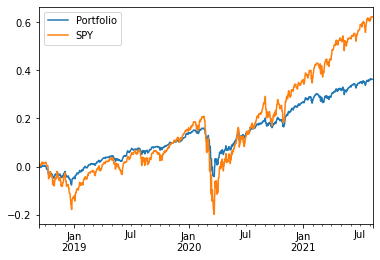

In [8]:
portfolio.benchmark('SPY').plot()

<AxesSubplot:>

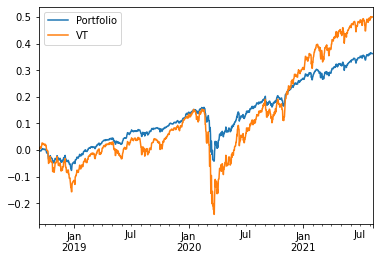

In [9]:
portfolio.benchmark('VT').plot()

<AxesSubplot:ylabel='Frequency'>

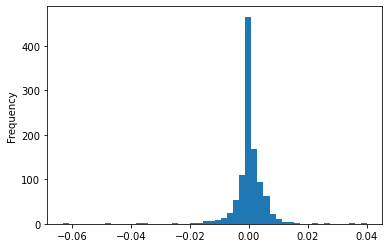

In [10]:
portfolio.daily_log_ret.plot.hist(bins=50)